### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

![ab_split](tm1.png "TM1")

### Переходим к практике

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lqw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

morph = pymorphy2.MorphAnalyzer()

151


In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-9-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 21 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 43s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

In [13]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [14]:
common_dictionary[19]

'директор'

Все просто - это словарь наших слов

Запускаем обучение

In [15]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 46.9 s


In [16]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [17]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.1495632),
 (3, 0.26683742),
 (13, 0.04633412),
 (16, 0.10342914),
 (23, 0.36213866),
 (24, 0.054669023)]

In [18]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints O[(20,
#   '0.016*"памятник" + 0.015*"пресссекретарить" + 0.015*"украина" + 0.014*"белоруссия" + 0.013*"общество" + 0.013*"квартира" + 0.010*"путин" + 0.010*"nn" + 0.010*"песок" + 0.009*"владимир"')nly Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: москва фестиваль налог nn год участник пройти
topic_1: статья рф тыс продукция автор пострадать автомобиль
topic_2: гражданин граница километр государство nn турция конкурс
topic_3: газ поверхность nn место германия рейтинг погода
topic_4: это россия который мочь российский сша страна
topic_5: экипаж штат скорость авария флот пилот годовой
topic_6: украина мозг пенсия год украинский лечение киев
topic_7: nn россия президент который это глава российский
topic_8: украина турецкий билет украинский власть киев минск
topic_9: производитель тверской мексиканский поспособствовать хх мэр собранный
topic_10: фонд дело рак орган уголовный обвинение преступление
topic_11: сотрудник эксперимент полиция дело задержать который это
topic_12: это год который мочь научный первый всё
topic_13: операция газета это миссия метод ru повышение
topic_14: год млрд рубль банк млн компания цена
topic_15: знаменитый звонок белый ливия присудить скрываться прозвище
topic_16: планета проверка снизить хорош

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [19]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))
    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [20]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])

In [21]:
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values

In [22]:
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]

In [23]:


topic_matrix.head(3)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.061057,0.0,0.0,0.000000,0.0,0.0,0.0,0.054643,0.0,...,0.0,0.000000,0.014145,0.0,0.0,0.0,0.0,0.0,0.012991,0.000000
1,4896,0.000000,0.0,0.0,0.256130,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.570488,0.000000
2,4897,0.149571,0.0,0.0,0.267185,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.103032,0.000000,0.0,0.0,0.0,0.0,0.0,0.361900,0.054949


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [25]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [26]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [27]:
get_user_embedding(user_articles_list)

array([0.00200907, 0.00594442, 0.03738235, 0.01521535, 0.17998359,
       0.00694561, 0.05369877, 0.25566738, 0.        , 0.        ,
       0.02650894, 0.0394123 , 0.02397032, 0.01705146, 0.        ,
       0.        , 0.00282305, 0.        , 0.02947878, 0.        ,
       0.        , 0.01544585, 0.08239015, 0.05579977, 0.1389147 ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [28]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.071526,0.082719,0.028660,0.005394,0.084054,0.000000,0.124078,0.058728,0.008978,...,0.0,0.004231,0.000000,0.005725,0.009663,0.000000,0.000000,0.076759,0.185693,0.148847
1,u108690,0.017608,0.018737,0.023635,0.002862,0.168086,0.000000,0.051967,0.129675,0.037592,...,0.0,0.003999,0.000000,0.003460,0.002023,0.000000,0.007872,0.089463,0.044543,0.146770
2,u108339,0.010353,0.046212,0.021866,0.014259,0.045559,0.013226,0.063148,0.199748,0.002966,...,0.0,0.002381,0.001769,0.006725,0.000000,0.002118,0.000000,0.080309,0.196245,0.058726


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [29]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [30]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.071526,0.082719,0.028660,0.005394,0.084054,0.000000,0.124078,0.058728,0.008978,...,0.004231,0.000000,0.005725,0.009663,0.000000,0.000000,0.076759,0.185693,0.148847,0
1,u108690,0.017608,0.018737,0.023635,0.002862,0.168086,0.000000,0.051967,0.129675,0.037592,...,0.003999,0.000000,0.003460,0.002023,0.000000,0.007872,0.089463,0.044543,0.146770,1
2,u108339,0.010353,0.046212,0.021866,0.014259,0.045559,0.013226,0.063148,0.199748,0.002966,...,0.002381,0.001769,0.006725,0.000000,0.002118,0.000000,0.080309,0.196245,0.058726,1


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [32]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [33]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [34]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10329644, 0.04071567, 0.52419166, 0.37857996, 0.02963948,
       0.06306746, 0.07957657, 0.42010639, 0.09882888, 0.06130332])

In [35]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.279731, F-Score=0.692, Precision=0.674, Recall=0.710


In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
import itertools

Confusion matrix, without normalization
[[1671   84]
 [  72  173]]


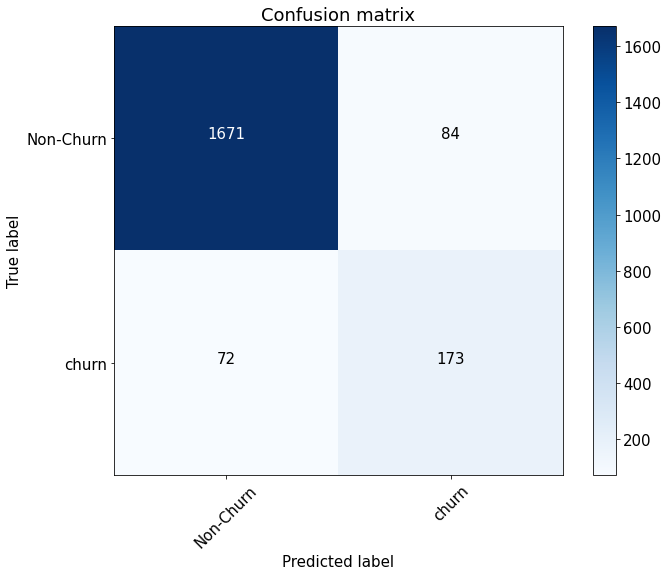

In [39]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [40]:
roc_auc_score(y_test, preds)

0.9485644514215942

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

# Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [41]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [42]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [43]:
def get_user_embedding_idf_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([tp[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [44]:
def get_user_embedding_df(fun):
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(fun, 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    return user_embeddings


In [45]:
def test_result_learning(fun):
    user_embeddings = get_user_embedding_df(fun)
    X = pd.merge(user_embeddings, target, 'left')
    X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}, Precision={precision[ix]}, Recall={recall[ix]}')
    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    print(f'auc - {roc_auc_score(y_test, preds)}')
    return roc_auc_score(y_test, preds),fscore[ix],precision[ix],recall[ix]
                                                                      
    
    

In [46]:
result = {}

Best Threshold=0.2797305005954801, F-Score=0.6918489065606361, Precision=0.6744186046511628, Recall=0.710204081632653
Confusion matrix, without normalization
[[1671   84]
 [  72  173]]


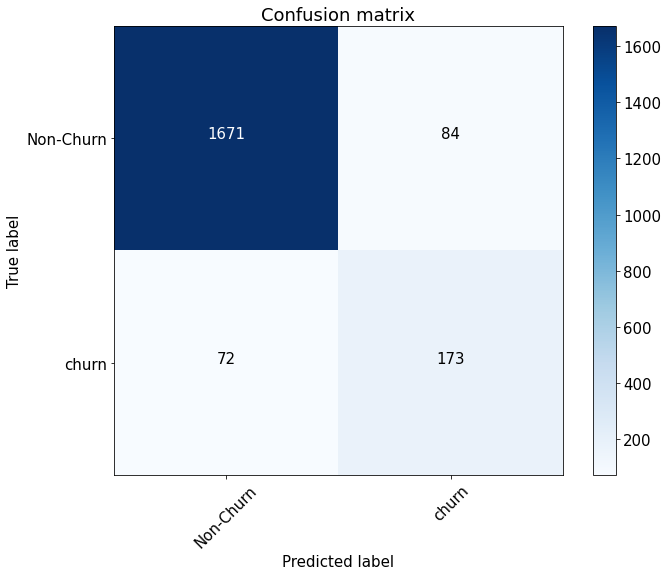

auc - 0.9485644514215942


In [47]:
# Результат на вебинаре
result['mean'] =test_result_learning(get_user_embedding)

Best Threshold=0.2947880906253705, F-Score=0.8278688524590163, Precision=0.831275720164609, Recall=0.8244897959183674
Confusion matrix, without normalization
[[1714   41]
 [  44  201]]


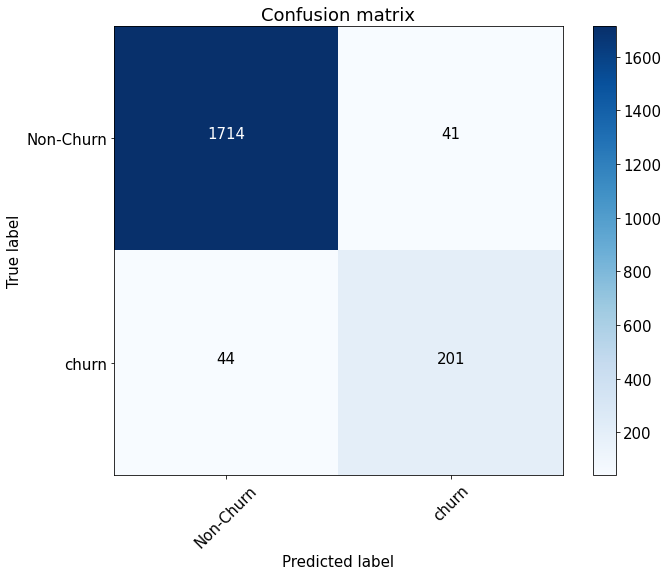

auc - 0.9814872957730101


In [48]:
# Результат с медианной
result['median']  = test_result_learning(get_user_embedding_median)

Best Threshold=0.3179217919908762, F-Score=0.7670682730923695, Precision=0.7549407114624506, Recall=0.7795918367346939
Confusion matrix, without normalization
[[1693   62]
 [  55  190]]


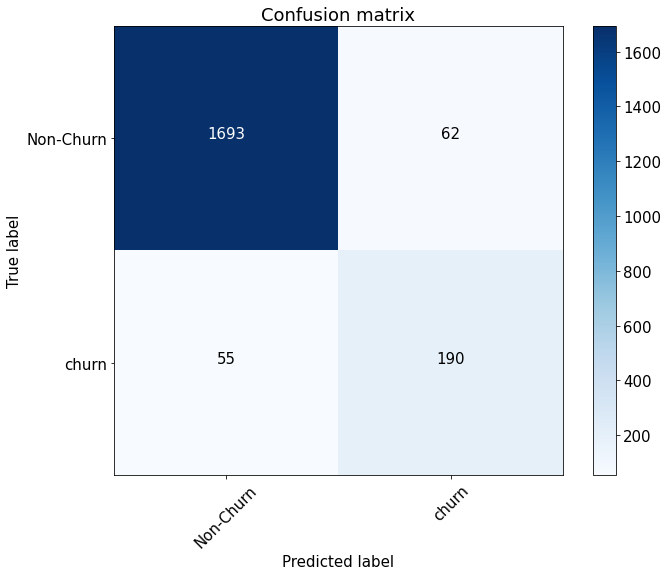

auc - 0.9625373568230712


In [49]:
# Результат с max
result['max'] = test_result_learning(get_user_embedding_max)

In [50]:
res = pd.DataFrame(result)

In [51]:
res.index = ['roc_auc','f1_score','precision','recall']

In [52]:
res

,mean,median,max
roc_auc,0.948564,0.981487,0.962537
f1_score,0.691849,0.827869,0.767068
precision,0.674419,0.831276,0.754941
recall,0.710204,0.824490,0.779592


Как видно при медиане max показатели улучшились,После каждого пересчета результаты меняются. max и mediana  меняются местами.

# Эксперименты с  Idf

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
tfidf = TfidfVectorizer()

In [55]:
tp = pd.DataFrame()

In [56]:
tp['docs_id']=news['doc_id']

In [57]:
my_tfidf = tfidf.fit_transform(news['title'].apply(lambda x: ', '.join(x),1))

In [58]:
%%time
my_vector=[]
for i in my_tfidf:
    a=np.where(i.toarray()!=0)[1]
    my_vector.append(tfidf.idf_[a].mean())
    
    

Wall time: 42.6 s


In [59]:
tp['weight'] = my_vector

In [60]:
tp

,docs_id,weight
0,6,4.883926
1,4896,4.965397
2,4897,4.681600
3,4898,4.641682
4,4899,4.975748
...,...,...
26995,513441,4.381100
26996,513442,4.444499
26997,513443,4.431585
26998,513444,4.327533


In [61]:
tp['weight'].describe()

count    27000.000000
mean         4.708674
std          0.479455
min          3.298814
25%          4.401234
50%          4.651205
75%          4.968503
max          8.053602
Name: weight, dtype: float64

In [62]:
users_ = users.copy()

In [63]:
a=list(map(lambda x:eval(x),users['articles'].values))

In [64]:
users_['articles'] = a

In [65]:
users_['articles']

0       [293672, 293328, 293001, 293622, 293126, 1852]
1               [3405, 1739, 2972, 1158, 1599, 322665]
2               [1845, 2009, 2356, 1424, 2939, 323389]
3               [5933, 6186, 5055, 6977, 5206, 488389]
4                [707, 1144, 2532, 2928, 3133, 324592]
                             ...                      
7995     [323918, 323362, 323704, 323452, 324291, 251]
7996            [5532, 5860, 7755, 7140, 5182, 488337]
7997    [322811, 323898, 321858, 323345, 323491, 2193]
7998            [5436, 6092, 6891, 7045, 5320, 487379]
7999    [294096, 293759, 294178, 293544, 293921, 2909]
Name: articles, Length: 8000, dtype: object

In [66]:
users_['articles_ratio'] = users_['articles'].apply(lambda x: np.array([tp[tp['docs_id']==i]['weight'].values[0]  for i in x]))


In [67]:
users_['articles_ratio']

0       [4.013690172450131, 5.240918028627772, 4.12346...
1       [4.415708276944557, 4.815370600866168, 4.70097...
2       [5.059285827675876, 4.7418763327790145, 4.5937...
3       [4.709798414506177, 5.605671794967433, 4.98582...
4       [4.613264566877303, 4.813505653558882, 5.21980...
                              ...                        
7995    [4.062011248159626, 4.468812254683797, 4.53267...
7996    [5.419337771687079, 5.066623625225241, 4.81321...
7997    [4.153632356951625, 4.142233019987925, 4.26663...
7998    [5.201370089849887, 5.08649834511191, 5.046570...
7999    [5.082179584862771, 5.135931110307721, 5.59316...
Name: articles_ratio, Length: 8000, dtype: object

In [68]:
users_['articles_ratio_mean'] = users_['articles_ratio'].apply(lambda x:x.mean())

In [69]:
users_['articles_ratio_max'] = users_['articles_ratio'].apply(lambda x:x.max())

In [70]:
users_['articles_ratio_median'] = users_['articles_ratio'].apply(lambda x:np.median(x))

In [71]:
users_

,uid,articles,articles_ratio,articles_ratio_mean,articles_ratio_max,articles_ratio_median
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]","[4.013690172450131, 5.240918028627772, 4.12346...",4.662899,5.289591,4.654866
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]","[4.415708276944557, 4.815370600866168, 4.70097...",4.565702,4.815371,4.617925
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]","[5.059285827675876, 4.7418763327790145, 4.5937...",4.659100,5.059286,4.595915
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]","[4.709798414506177, 5.605671794967433, 4.98582...",4.890083,5.605672,4.840417
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]","[4.613264566877303, 4.813505653558882, 5.21980...",4.735969,5.219808,4.631162
...,...,...,...,...,...,...
7995,u107463,"[323918, 323362, 323704, 323452, 324291, 251]","[4.062011248159626, 4.468812254683797, 4.53267...",4.475762,5.547408,4.381378
7996,u101241,"[5532, 5860, 7755, 7140, 5182, 488337]","[5.419337771687079, 5.066623625225241, 4.81321...",4.916224,5.419338,4.795552
7997,u106486,"[322811, 323898, 321858, 323345, 323491, 2193]","[4.153632356951625, 4.142233019987925, 4.26663...",4.463364,5.031436,4.334905
7998,u102220,"[5436, 6092, 6891, 7045, 5320, 487379]","[5.201370089849887, 5.08649834511191, 5.046570...",4.887605,5.201370,4.924288


In [72]:
def test_result_learning_idf():
    user_work = X.copy()
    user_work['articles_ratio_mean'] = StandardScaler().fit_transform(users_['articles_ratio_mean'].values.reshape(-1,1))
    user_work['articles_ratio_max'] = MinMaxScaler().fit_transform(users_['articles_ratio_max'].values.reshape(-1,1))
    user_work['articles_ratio_median'] = MinMaxScaler().fit_transform(users_['articles_ratio_median'].values.reshape(-1,1))
    X_train, X_test, y_train, y_test = train_test_split(user_work.drop(['uid','churn'], axis=1),
                                                    user_work['churn'], random_state=0)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    preds = logreg.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]}, Precision={precision[ix]}, Recall={recall[ix]}')
    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()
    print(f'auc - {roc_auc_score(y_test, preds)}')
    return roc_auc_score(y_test, preds),fscore[ix],precision[ix],recall[ix]

In [73]:
user_embeddings = get_user_embedding_df(get_user_embedding)
X = pd.merge(user_embeddings, target, 'left')

Best Threshold=0.2656969054552737, F-Score=0.7557251908396946, Precision=0.7096774193548387, Recall=0.8081632653061225
Confusion matrix, without normalization
[[1674   81]
 [  48  197]]


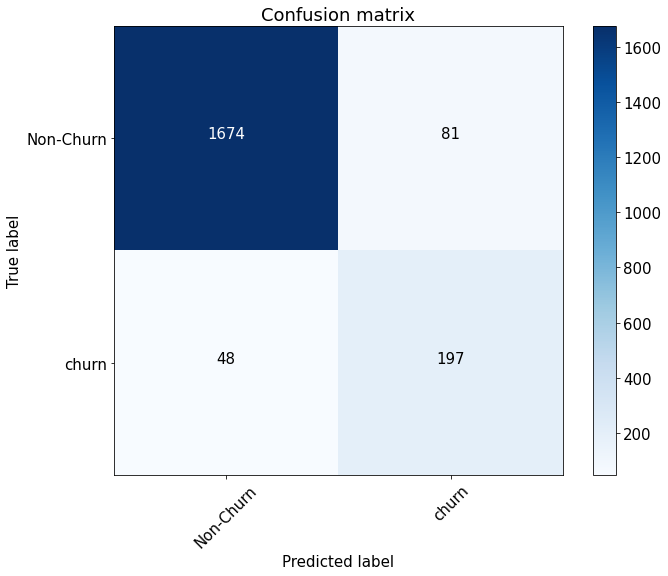

auc - 0.9699889528460957


In [74]:
result['idx_mean'] = test_result_learning_idf()

In [75]:
user_embeddings = get_user_embedding_df(get_user_embedding_median)
X = pd.merge(user_embeddings, target, 'left')

Best Threshold=0.3533272903436695, F-Score=0.8405172413793103, Precision=0.8904109589041096, Recall=0.7959183673469388
Confusion matrix, without normalization
[[1731   24]
 [  51  194]]


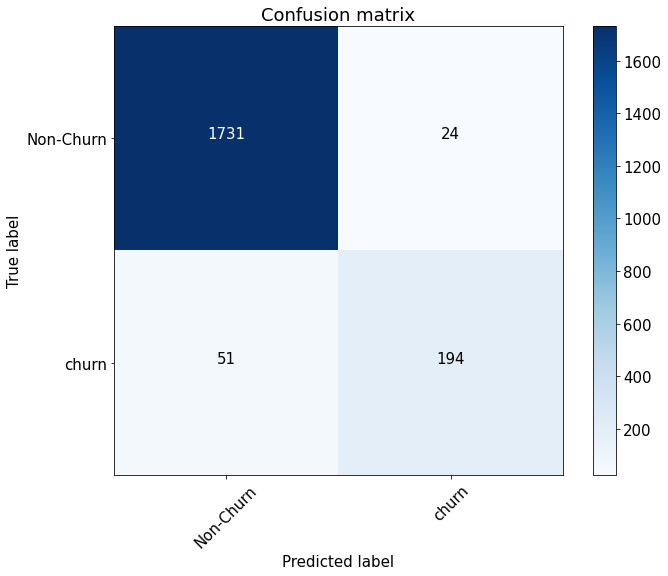

auc - 0.9853340310483167


In [76]:
result['idx_median'] = test_result_learning_idf()

In [77]:
user_embeddings = get_user_embedding_df(get_user_embedding_max)
X = pd.merge(user_embeddings, target, 'left')

Best Threshold=0.2379434913453533, F-Score=0.8304761904761905, Precision=0.7785714285714286, Recall=0.889795918367347
Confusion matrix, without normalization
[[1693   62]
 [  28  217]]


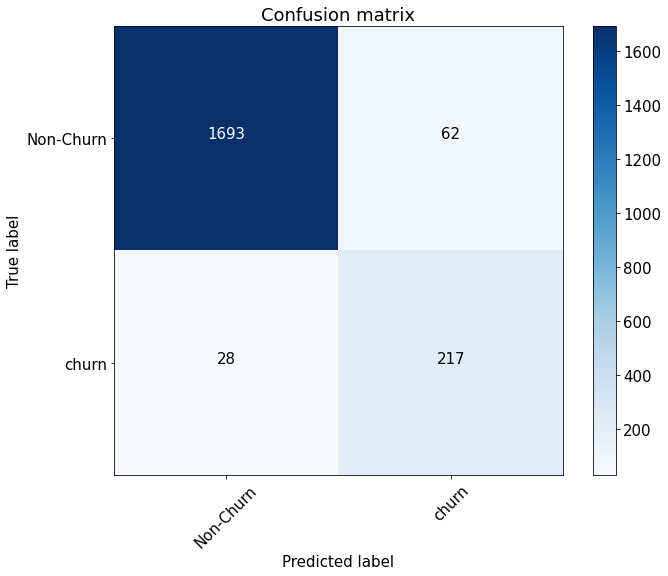

auc - 0.9834804349090064


In [78]:
result['idx_max'] = test_result_learning_idf()

In [79]:
res['idx_mean'] = result['idx_median']

In [80]:
res['idx_median'] = result['idx_median']

In [81]:
res['idx_max'] = result['idx_max']

In [82]:
res

,mean,median,max,idx_mean,idx_median,idx_max
roc_auc,0.948564,0.981487,0.962537,0.985334,0.985334,0.983480
f1_score,0.691849,0.827869,0.767068,0.840517,0.840517,0.830476
precision,0.674419,0.831276,0.754941,0.890411,0.890411,0.778571
recall,0.710204,0.824490,0.779592,0.795918,0.795918,0.889796


Результапты говорят сами за себя

После каждого пересчета результаты меняются. max и mediana  меняются местами.